In [5]:
!pip install pytesseract


In [86]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Function to load and preprocess an image
def load_image(image_path, max_size=1024):
    if not os.path.exists(image_path):
        return None
    image = cv2.imread(image_path)
    if image is None:
        return None
    # Resize image if too large
    h, w, _ = image.shape
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        image = cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Function to visualize YOLO results
def plot_yolo_results(image, results):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")

    h, w, _ = image.shape
    
    for detection in results.xyxy[0]:
        x1, y1, x2, y2, confidence, cls = detection.tolist()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        confidence = round(confidence, 2)
        
        # Calculate box width and apply expansion
        box_width = x2 - x1
        expand_amount = int(box_width * 0.05)
        
        # Adjust box coordinates
        x1 = max(0, x1 - expand_amount)  # Ensure not beyond image boundary
        x2 = min(w, x2 + expand_amount)
        
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="green", linewidth=2)
        )
        label = f"Class {int(cls)} ({confidence})"
        plt.text(x1, y1 - 5, label, color="white", fontsize=12, bbox=dict(facecolor="green", alpha=0.7))

    %matplotlib inline
    plt.show()  # Use this explicitly if running as a script


    # Path to images
image_dir = "APS360_Project_Dataset/daimage_dirtaset2/images/test"  # Replace with your image directory
weights_path = 'yolov5/runs/train/card_number_detector6/weights/best.pt'

yolo_model = torch.hub.load('yolov5', 'custom', path=weights_path, source='local')
yolo_model = yolo_model.to('cpu')  # Force to CPU if GPU memory is limited


YOLOv5 🚀 2024-11-19 Python-3.8.20 torch-2.4.1 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Image successfully loaded.


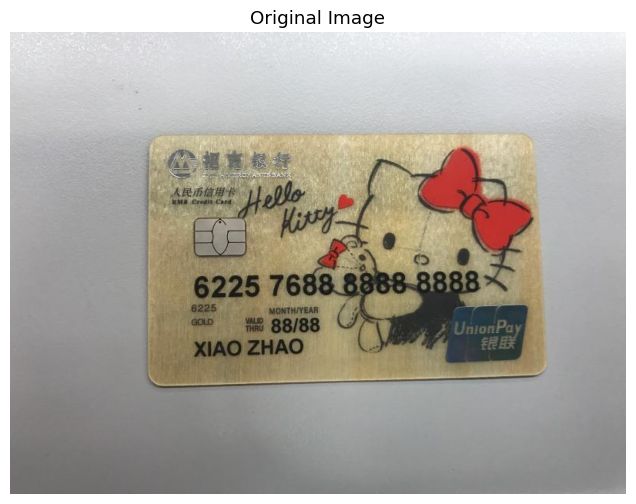

/Users/johnson/card_number_detection/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


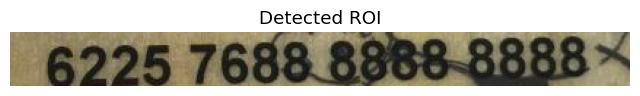

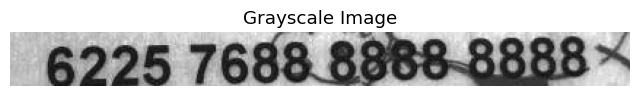

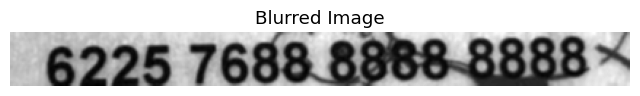

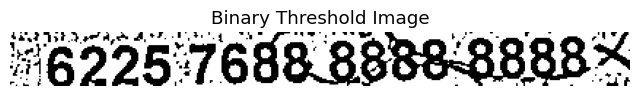

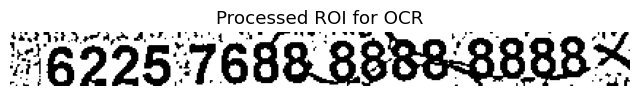

OCR Result: 385957688888888

Detected Card Number: 385957688888888
Final Detected Card Number: 385957688888888


In [117]:
import pytesseract
import cv2
from matplotlib import pyplot as plt

def display_image(title, image, cmap=None):
    """Display an image using matplotlib."""
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_image(roi):
    """
    Preprocess the cropped ROI for OCR.
    Args:
        roi: Cropped region of the image containing the text.
    Returns:
        Processed ROI suitable for OCR.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    display_image("Grayscale Image", gray, cmap='gray')

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    display_image("Blurred Image", blurred, cmap='gray')

    # Apply Adaptive Thresholding to binarize the image
    binary_thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    display_image("Binary Threshold Image", binary_thresh, cmap='gray')


    return binary_thresh

def extract_card_number(image, yolo_model):
    """Detect and extract card numbers from the image using YOLO and Tesseract."""
    # Detect ROI using YOLO
    results = yolo_model(image)
    if len(results.xyxy[0]) == 0:
        print("No detections found by YOLO.")
        return None

    for detection in results.xyxy[0]:
        x1, y1, x2, y2, confidence, cls = detection.tolist()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # Extract ROI
        roi = image[y1:y2, x1:x2]
        if roi.size == 0:
            print("Error: ROI is empty.")
            continue

        display_image("Detected ROI", cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

        # Preprocess ROI
        processed_roi = preprocess_image(roi)
        display_image("Processed ROI for OCR", processed_roi, cmap='gray')

        # Run OCR on the processed ROI with digits-only whitelist
        custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'
        text = pytesseract.image_to_string(processed_roi, config=custom_config)
        print("OCR Result:", text)

        # Extract only numbers
        card_number = ''.join(filter(str.isdigit, text))
        print("Detected Card Number:", card_number)

        return card_number

    print("No valid detections found.")
    return None

# Main Functionality

# image_path = 'APS360_Project_Dataset/dataset5/img/25.jpg'
image_path = 'APS360_Project_Dataset/dataset5/img/222.jpg'

image = cv2.imread(image_path)

if image is None:
    print("Error: Image could not be loaded.")
else:
    print("Image successfully loaded.")
    display_image("Original Image", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Adjust YOLO confidence threshold if necessary
    yolo_model.conf = 0.25  # Lower threshold if detections are missing
    card_number = extract_card_number(image, yolo_model)
    
    if card_number:
        print(f"Final Detected Card Number: {card_number}")
    else:
        print("Card number could not be detected.")


In [104]:
import pytesseract
import cv2
from matplotlib import pyplot as plt

def display_image(title, image, cmap=None):
    """Display an image using matplotlib."""
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_image(image):
    """
    Preprocess the image for OCR.
    Args:
        image: Entire input image containing the text.
    Returns:
        Processed image suitable for OCR.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    display_image("Grayscale Image", gray, cmap='gray')

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    display_image("Blurred Image", blurred, cmap='gray')

    # Apply Adaptive Thresholding to binarize the image
    binary_thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    display_image("Binary Threshold Image", binary_thresh, cmap='gray')

    # Resize for better OCR results
    scale_factor = 2  # Scale up by 2x
    height, width = binary_thresh.shape[:2]
    resized = cv2.resize(binary_thresh, (width * scale_factor, height * scale_factor), interpolation=cv2.INTER_LINEAR)
    display_image("Resized Image for OCR", resized, cmap='gray')

    return resized

def extract_card_number(image):
    """Extract card numbers from the entire image using Tesseract."""
    # Preprocess the image
    processed_image = preprocess_image(image)
    display_image("Processed Image for OCR", processed_image, cmap='gray')

    # Run OCR on the processed image with digits-only whitelist
    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'
    text = pytesseract.image_to_string(processed_image, config=custom_config)
    print("OCR Result:", text)

    # Extract only numbers
    card_number = ''.join(filter(str.isdigit, text))
    print("Detected Card Number:", card_number)

    return card_number

# Main Functionality

# Path to the input image
image_path = 'numbers.jpg'

# Load the image
image = cv2.imread(image_path)

if image is None:
    print("Error: Image could not be loaded.")
else:
    print("Image successfully loaded.")
    display_image("Original Image", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Extract card number from the entire image
    card_number = extract_card_number(image)
    
    if card_number:
        print(f"Final Detected Card Number: {card_number}")
    else:
        print("Card number could not be detected.")


Error: Image could not be loaded.


[ WARN:0@9375.637] global loadsave.cpp:241 findDecoder imread_('/mnt/data/image.png'): can't open/read file: check file path/integrity
